# Asymptotics for the Late Arrivals Problem

In [16]:
import eda
import mdone
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as linalg
import scipy.sparse as sparse
import logging
import os
from math import log, ceil

In [17]:
CWD = os.getcwd()
FIGFLDR = os.path.join(CWD, 'figures')

In [2]:
sns.set(style='darkgrid', context='notebook')

In [3]:
def calc_pi(A):
    Asp = sparse.csr_matrix(A[:-1, :-1].T)
    v, w = sparse.linalg.eigs(Asp, k=1, M=sparse.eye(*Asp.shape, dtype=A.dtype), sigma=1+0j, which='LM')
    pisparse = w/sum(w)
    return Asp, v, pisparse

def check_pi(A, v, w, r, q):
    logger = logging.getLogger('eda.nbook.chkpi')
    logger.debug('rho %.4f & q %.4f | Eigenvalue %.2f + j%.2f', r, q, v.real, v.imag)
    check = np.sum(np.abs(A*w - w))
    logger.debug('Check: %e   | should be zero', check)
    
def jointp(pi, r, q):
    logger = logging.getLogger('eda.nbook.joint')
    prec = np.float64
    sysdim = pi.shape[0]+1
    k = eda.maxtriangno(sysdim)
    jointp = np.zeros((k, k), dtype=prec)
    for i in range(len(pi)):
            nn, ll = eda.indextonl(i)
            if ll == k:
                continue
            jointp[nn, ll] = pi[i][0].real
    logger.debug('Check: %e   | should be %.3f', jointp[0].sum(), 1-r)
    return jointp

def calc_pnl(r, q):
    t = eda.optimal_trunc(r, q)
    A = eda.computeMatrix_sp(t, r, q)
    res = calc_pi(A)
    check_pi(*res, r, q)
    jp = jointp(res[2], r, q)
    return jp

In [4]:
logger = logging.getLogger('eda.nbook')
logger.debug('Started')

In [5]:
jms = {}
mdo = {}

In [6]:
def calc_md1(r):
    model = mdone.MD1(r)
    trunc = xmax = ceil(-9*log(10)/log(r))
    model.set_roots(trunc)
    return model.pi(trunc)

## Study of performance

### Values of $\rho, q$ smaller than 0.9

In [7]:
RHO_restricted = np.linspace(0.1, 0.9, 5, dtype=np.float64)
QQQ_restricted = np.linspace(0.1, 0.9, 5, dtype=np.float64)
rqs_restricted = np.array(np.meshgrid(
    RHO_restricted,
    QQQ_restricted)).T.reshape(-1,2)

In [8]:
for r, q in rqs_restricted:
    foo = mdo.get(str(r))
    if foo is None:
        mdo[str(r)] = calc_md1(r)
    foo = jms.get((str(r), str(q)))
    if foo is None:
        jms[(str(r), str(q))] = calc_pnl(r, q)

/Users/clancia/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


#### Bivariate stationary distribution

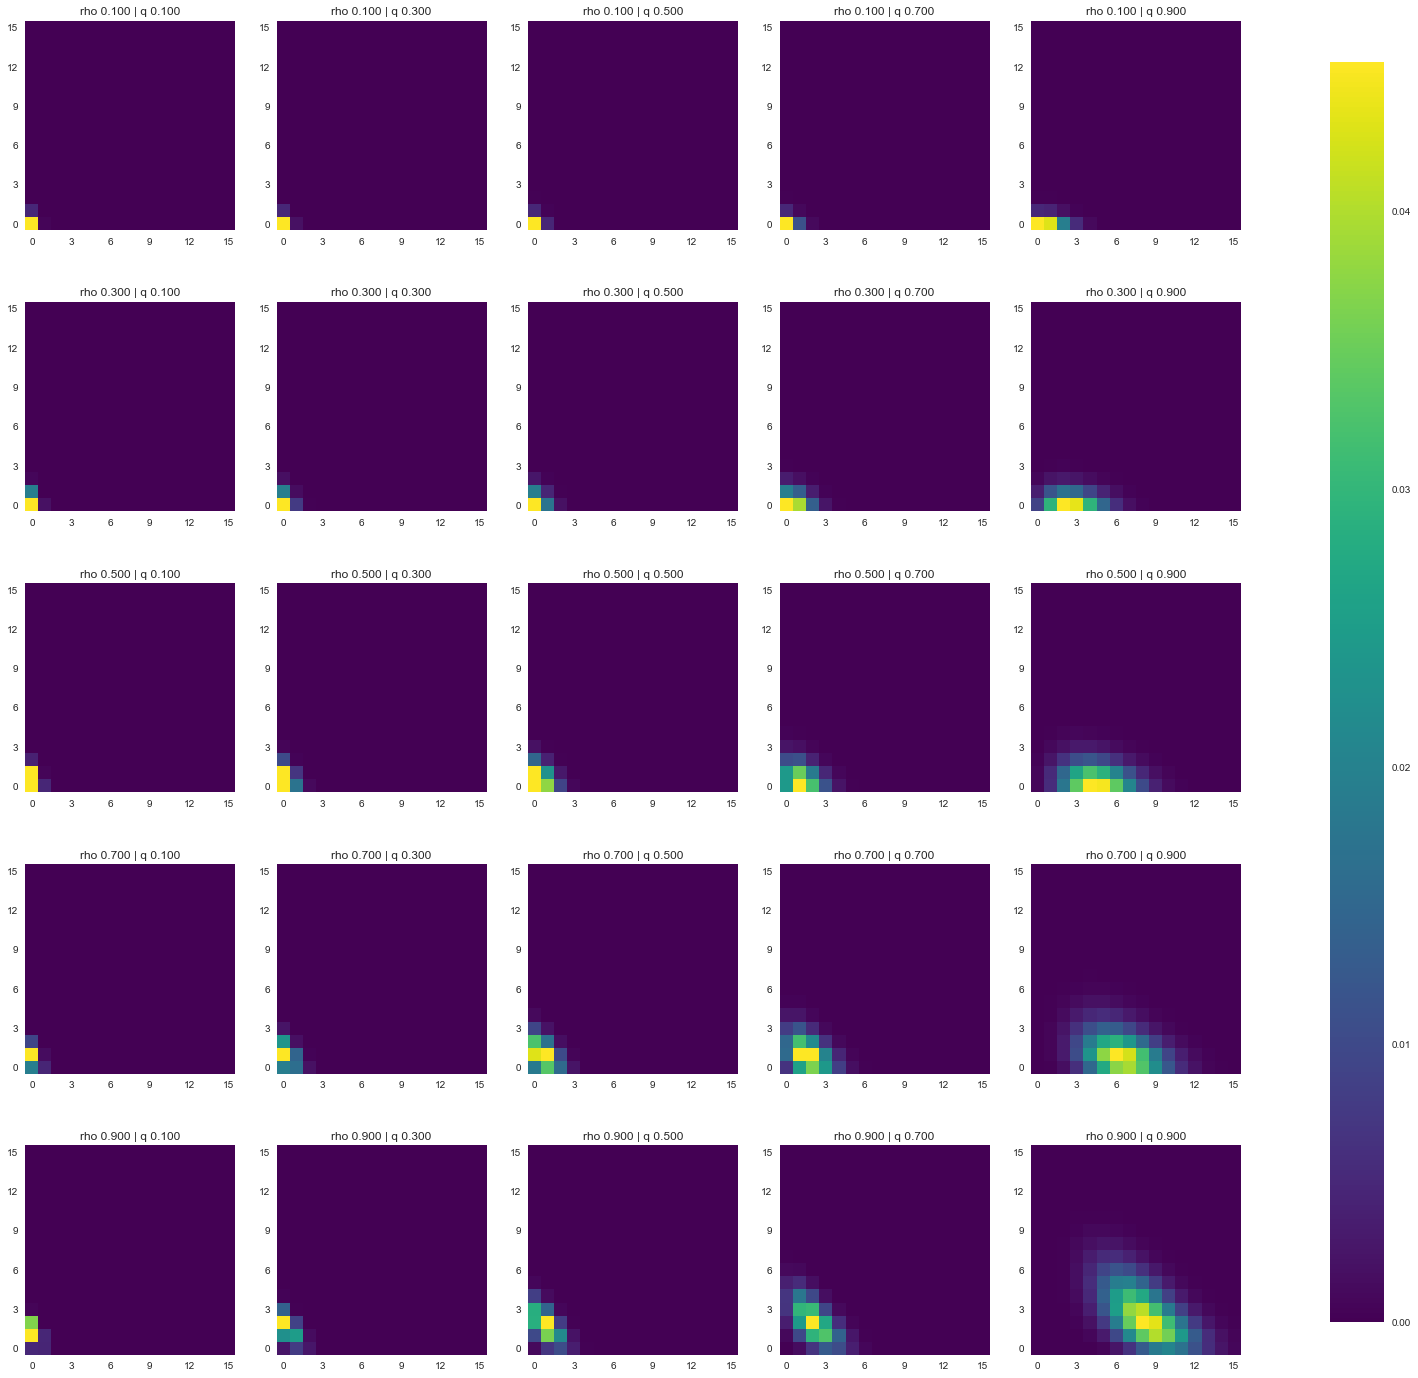

In [27]:
f, axes = plt.subplots(5, 5, figsize=(25, 25))
for ax, k in zip(axes.flatten(), rqs_restricted):
    r, q = k
    sqside = 16
    pnl = jms.get((str(r), str(q)))[:sqside,:sqside]
    side = pnl.shape[0]
    pnl = np.pad(pnl, pad_width=[(0, sqside-side), (0, sqside-side)],
                  mode='constant', constant_values=0)
    im = ax.imshow(pnl, origin='lower', cmap='viridis', aspect='equal')
    ax.set_title('rho {:.3f} | q {:.3f}'.format(r, q))
    ax.grid(False)
    ax.set_xticks(range(0,sqside,3))
    ax.set_yticks(range(0,sqside,3))

f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.15, 0.03, 0.7])
f.colorbar(im, cax=cbar_ax)
path = os.path.join(FIGFLDR, 'jointp_lowparms.png')
f.savefig(path, dpi=300, bbox_inches='tight')
plt.show()

#### Marginal distribution of the queue and comparison with M/D/1

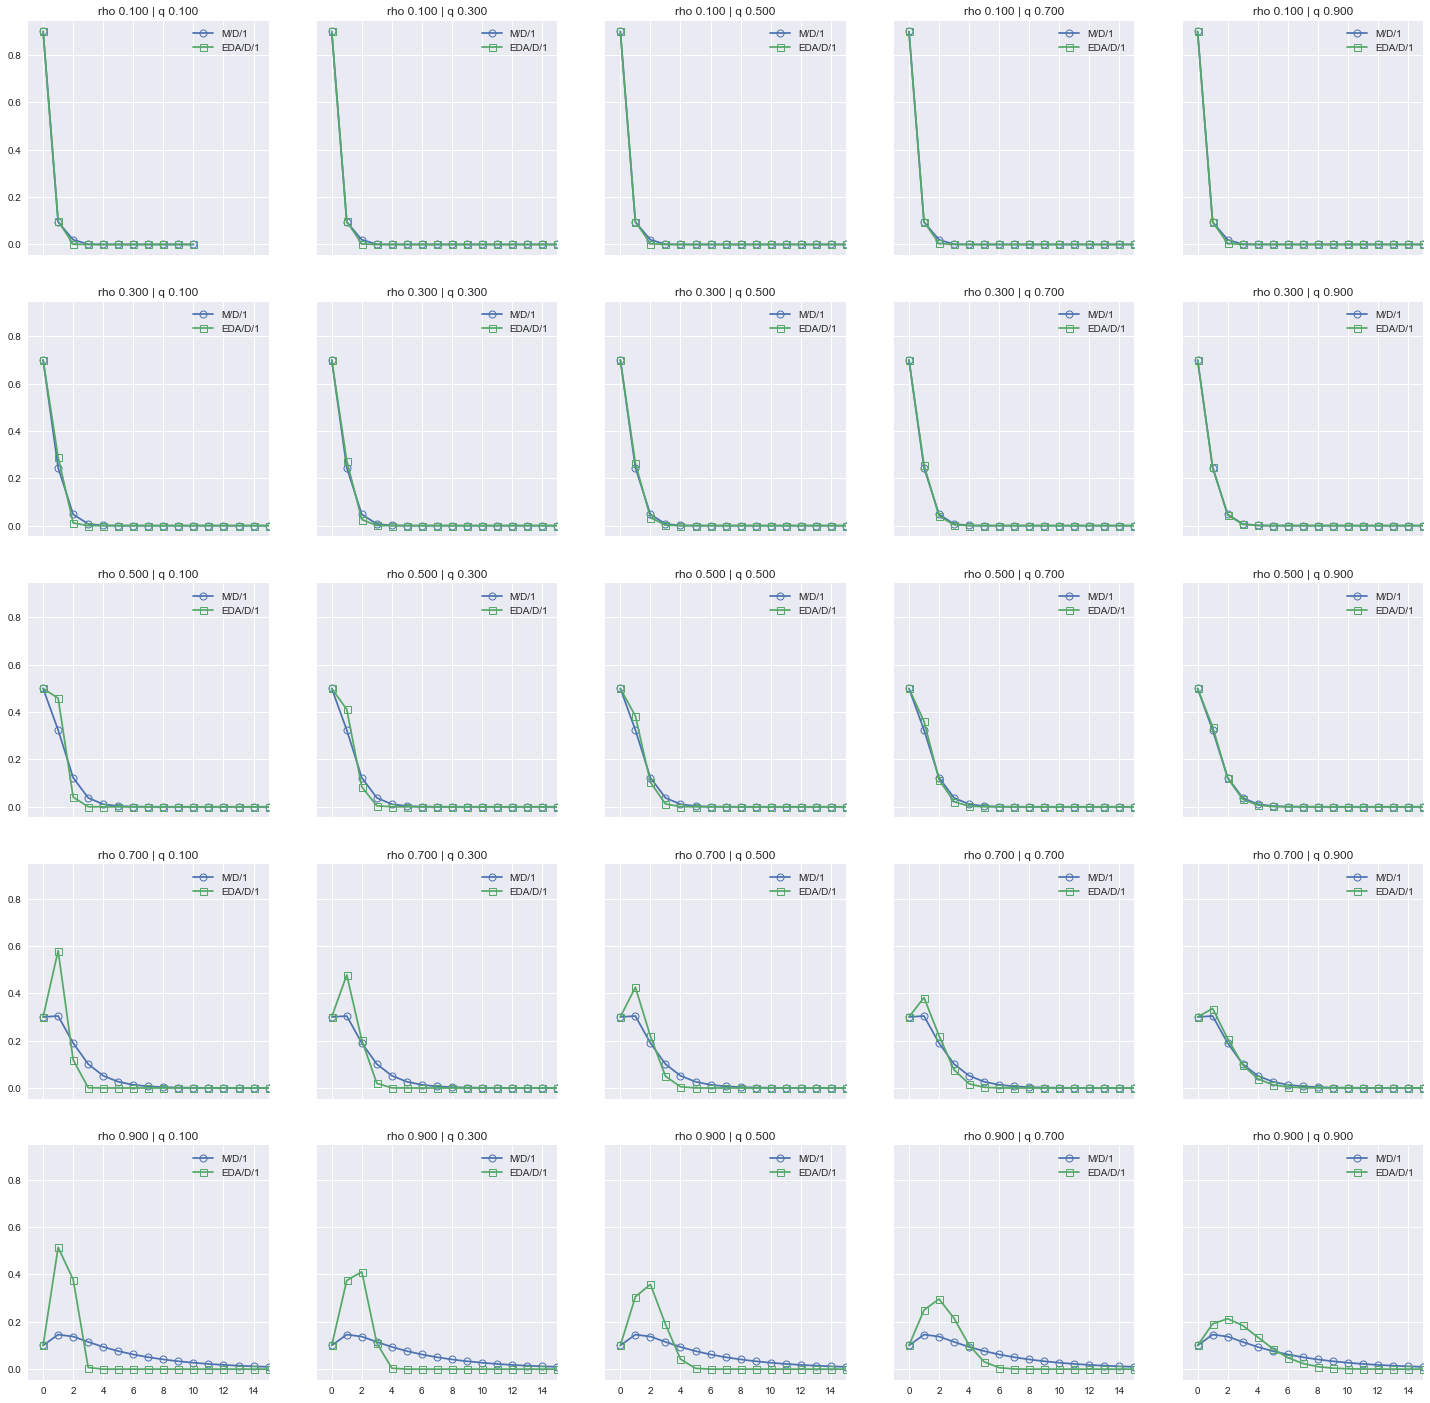

In [19]:
palette = sns.color_palette()
f, axes = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(25, 25))
for ax, k in zip(axes.flatten(), rqs_restricted):
    r, q = k
    pn = jms.get((str(r), str(q))).sum(axis=1)
    pi = mdo.get(str(r))
    maxlen = max(len(pn), len(pi))
    pn = np.pad(pn, pad_width=(0, maxlen-len(pn)),
                  mode='constant', constant_values=0)
    pp = np.pad(pi, pad_width=(0, maxlen-len(pi)),
                  mode='constant', constant_values=0)
    ax.plot(range(maxlen), pp,  marker='o',
            markerfacecolor='none', markeredgecolor=palette[0],
            markeredgewidth=1, label='M/D/1')
    ax.plot(range(maxlen), pn,  marker='s',
            markerfacecolor='none', markeredgecolor=palette[1],
            markeredgewidth=1, label='EDA/D/1')
    xmax = 15
    ax.set_xlim(-1, xmax)
    ax.set_title('rho {:.3f} | q {:.3f}'.format(r, q))
    ax.legend()
path = os.path.join(FIGFLDR, 'marginalqueue_lowparms.png')
f.savefig(path, dpi=300, bbox_inches='tight')
plt.show()

#### Mean queue length

In [11]:
RHO = np.linspace(0.1, 0.9, 9, dtype=np.float64)
QQQ = np.linspace(0.1, 0.9, 9, dtype=np.float64)
rqs = np.array(np.meshgrid(RHO, QQQ)).T.reshape(-1,2)

In [12]:
for r, q in rqs:
    foo = mdo.get(str(r))
    if foo is None:
        mdo[str(r)] = calc_md1(r)
    foo = jms.get((str(r), str(q)))
    if foo is None:
        jms[(str(r), str(q))] = calc_pnl(r, q)

In [13]:
def mean_queue_len(k, jms=jms):
    pn = jms.get(k).sum(axis=1)
    nn = np.arange(len(pn))
    return (pn*nn).sum()

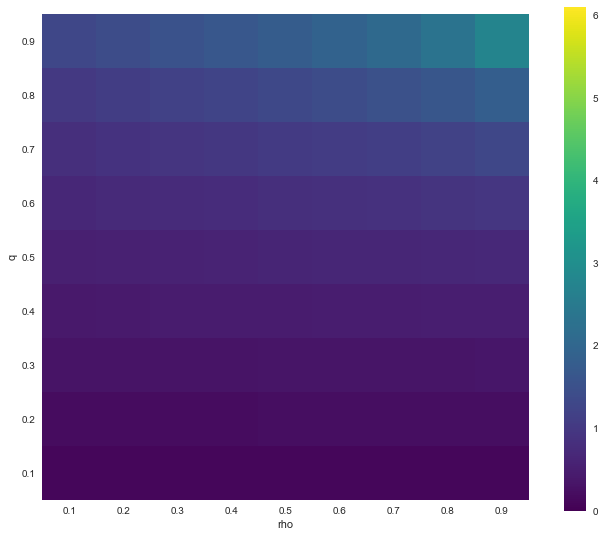

In [39]:
mql = np.empty((len(RHO), len(QQQ)))
rndx = np.arange(len(RHO))
qndx = np.arange(len(QQQ))
indices = np.array(np.meshgrid(
    np.arange(len(RHO)),
    np.arange(len(QQQ)))).T.reshape(-1,2)
for (r, q), (i, j) in zip(rqs, indices):
    k = (str(r), str(q))
    mql[i, j] = mean_queue_len(k)
f, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(mql, origin='lower', cmap='viridis', vmin=0, vmax=6.1)
ax.grid(False)
ax.set_xticks(rndx)
ax.set_xticklabels(RHO)
ax.set_xlabel('rho')
ax.set_yticks(qndx)
ax.set_yticklabels(QQQ)
ax.set_ylabel('q')

f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.15, 0.03, 0.7])
f.colorbar(im, cax=cbar_ax)
path = os.path.join(FIGFLDR, 'meanqueue_lowparms.png')
f.savefig(path, dpi=300, bbox_inches='tight')
plt.show()

In [13]:
def mean_queue_len(k, jms=jms):
    pn = jms.get(k).sum(axis=1)
    nn = np.arange(len(pn))
    return (pn*nn).sum()

### Values of $\rho, q$ higher than 0.9

In [28]:
RHO_high = np.linspace(0.9, 1, 5, endpoint=False, dtype=np.float64)
QQQ_high = np.linspace(0.9, 0.95, 5, dtype=np.float64)
rqs_high = np.array(np.meshgrid(RHO_high, QQQ_high)).T.reshape(-1,2)

In [ ]:
for r, q in rqs_high:
    foo = mdo.get(str(r))
    if foo is None:
        mdo[str(r)] = calc_md1(r)
    foo = jms.get((str(r), str(q)))
    if foo is None:
        jms[(str(r), str(q))] = calc_pnl(r, q)

#### Bivariate stationary distribution

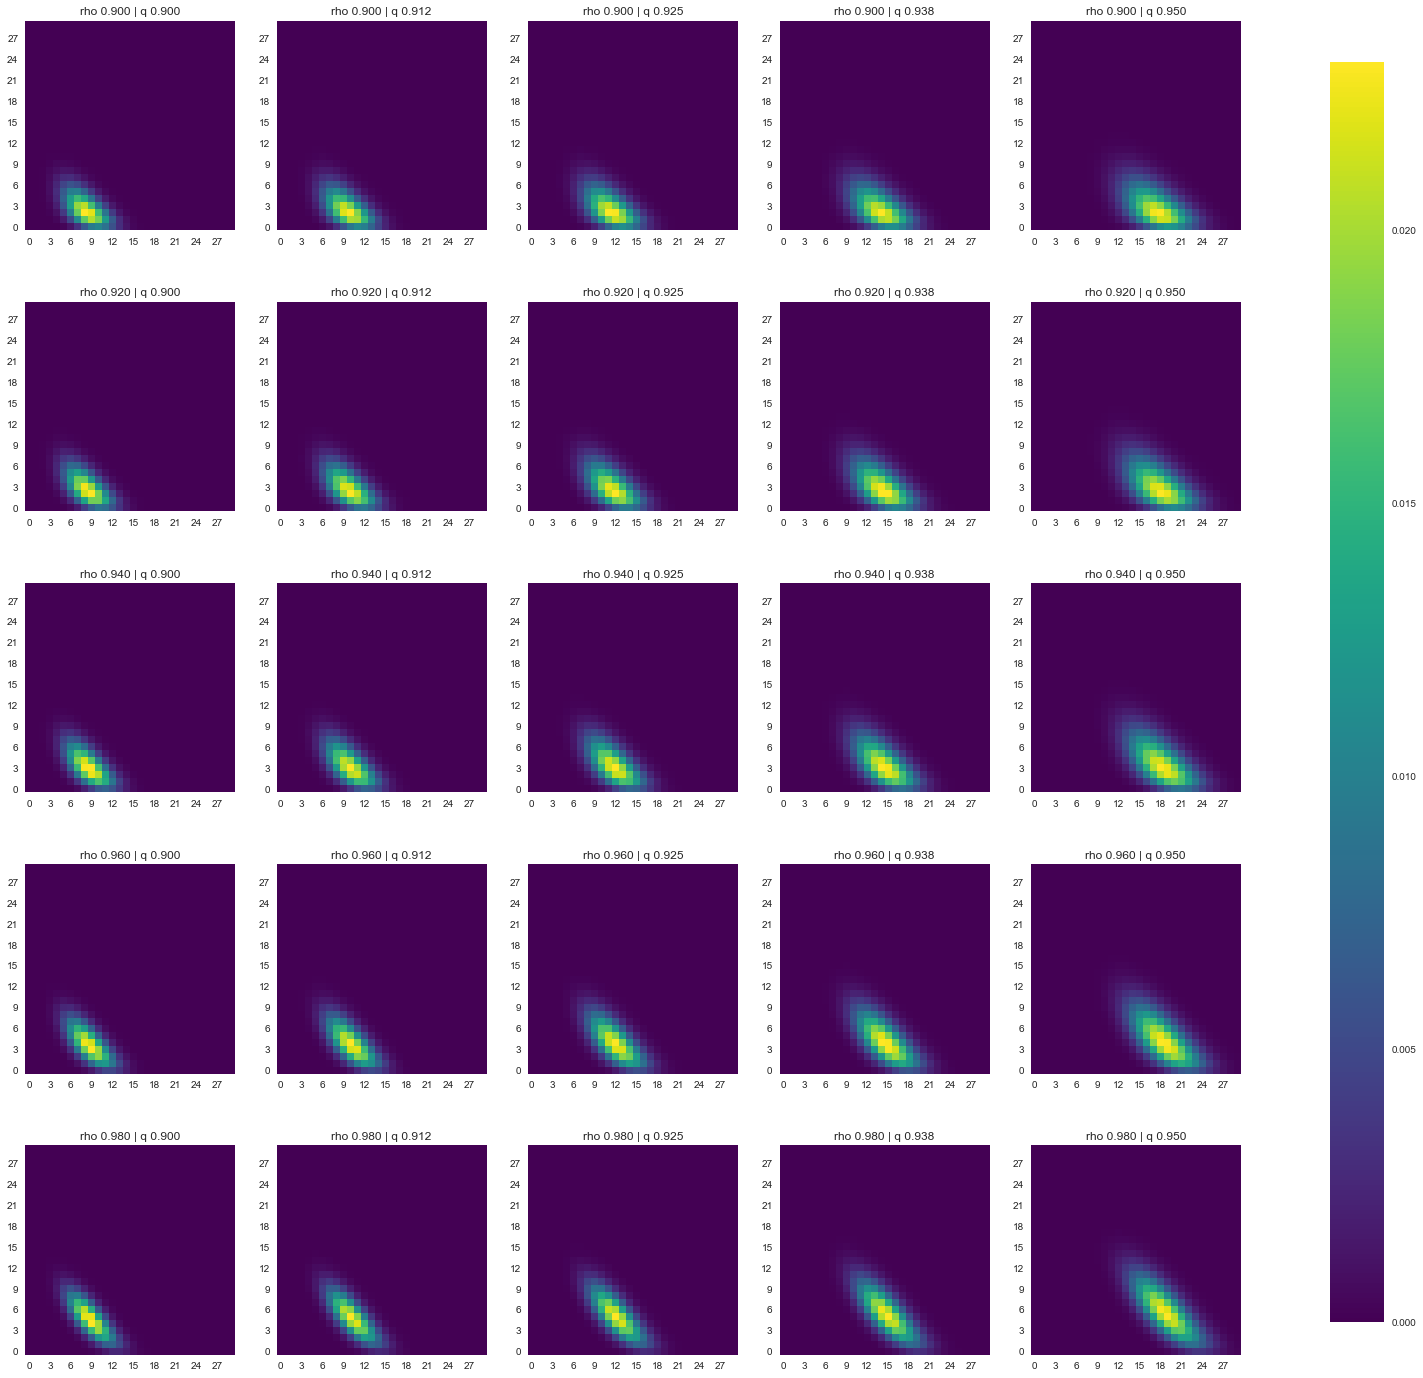

In [32]:
f, axes = plt.subplots(5, 5, figsize=(25, 25))
for ax, k in zip(axes.flatten(), rqs_high):
    r, q = k
    sqside = 30
    pnl = jms.get((str(r), str(q)))[:sqside,:sqside]
    side = pnl.shape[0]
    pnl = np.pad(pnl, pad_width=[(0, sqside-side), (0, sqside-side)],
                  mode='constant', constant_values=0)
    im = ax.imshow(pnl, origin='lower', cmap='viridis', aspect='equal')
    ax.set_title('rho {:.3f} | q {:.3f}'.format(r, q))
    ax.grid(False)
    ax.set_xticks(range(0,sqside,3))
    ax.set_yticks(range(0,sqside,3))

f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.15, 0.03, 0.7])
f.colorbar(im, cax=cbar_ax)
path = os.path.join(FIGFLDR, 'jointp_highparms.png')
f.savefig(path, dpi=300, bbox_inches='tight')
plt.show()

#### Marginal distribution of the queue and comparison with M/D/1

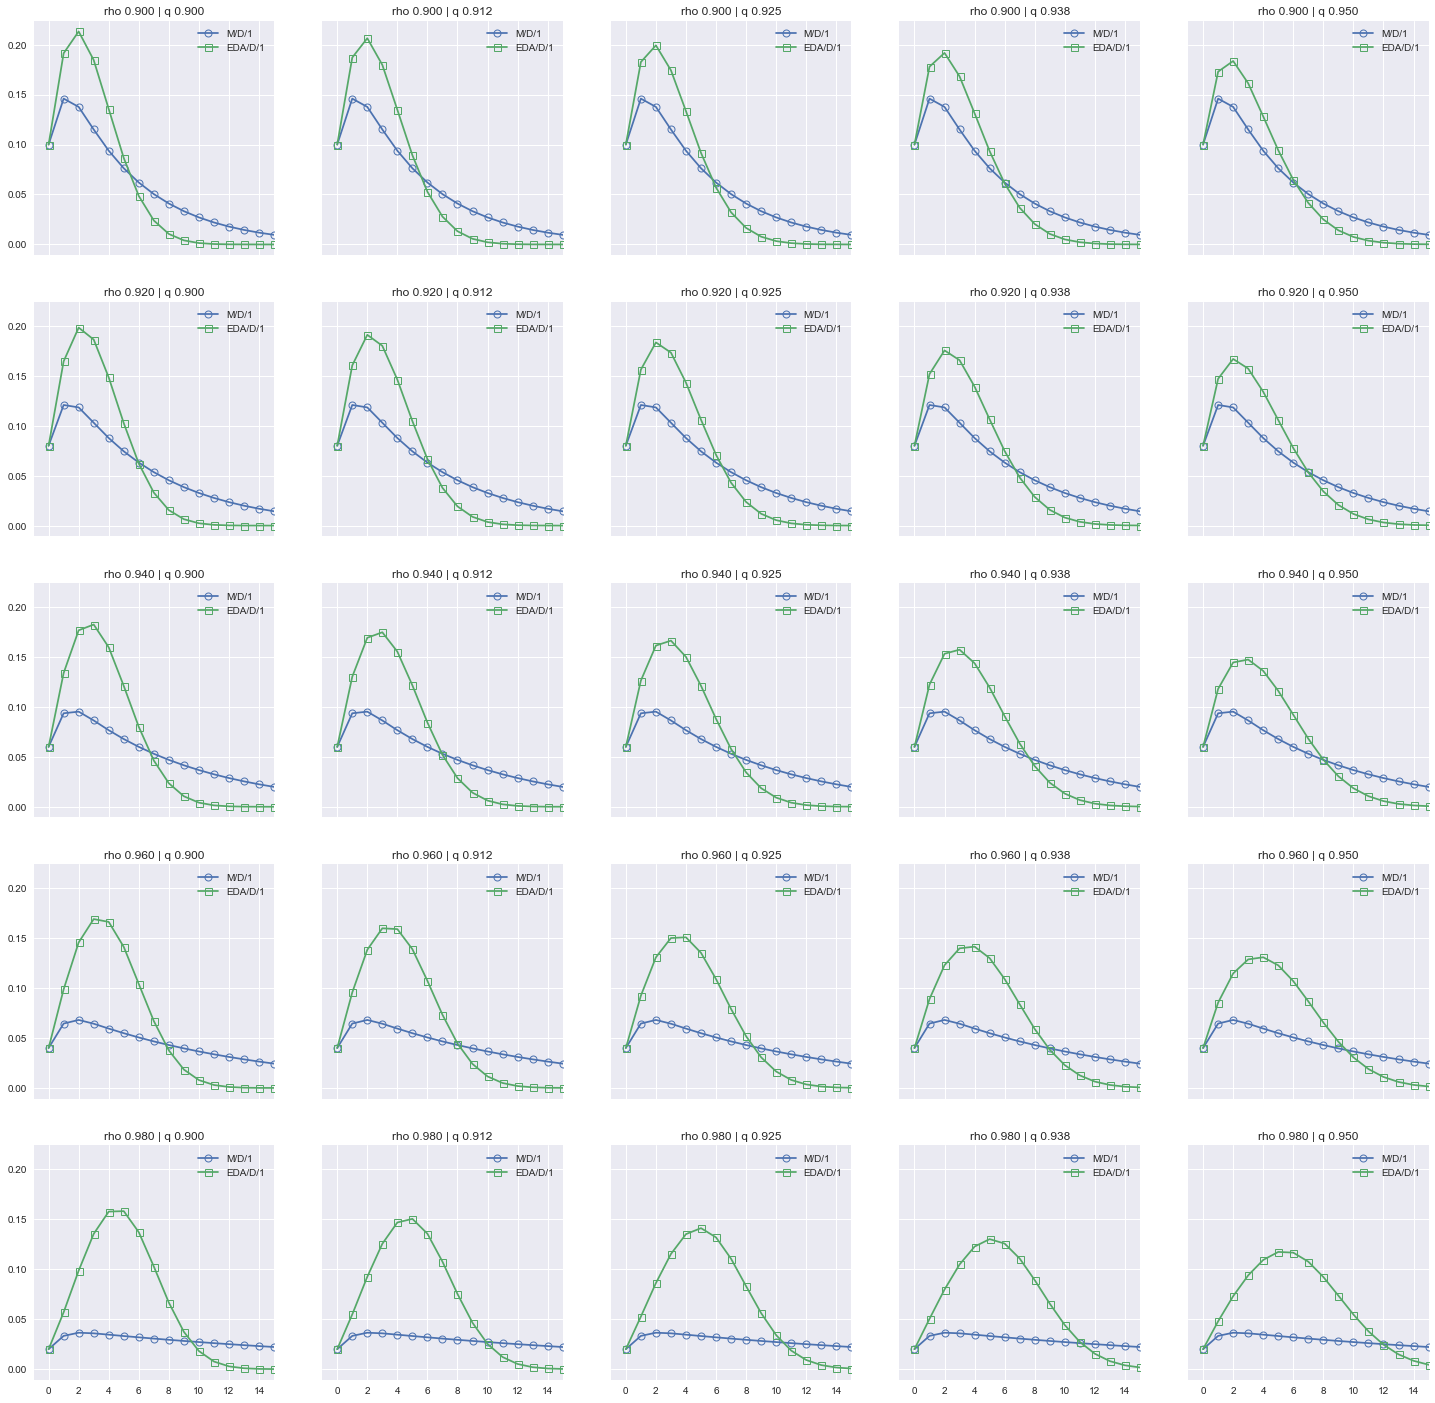

In [33]:
palette = sns.color_palette()
f, axes = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(25, 25))
for ax, k in zip(axes.flatten(), rqs_high):
    r, q = k
    pn = jms.get((str(r), str(q))).sum(axis=1)
    pi = mdo.get(str(r))
    maxlen = max(len(pn), len(pi))
    pn = np.pad(pn, pad_width=(0, maxlen-len(pn)),
                  mode='constant', constant_values=0)
    pp = np.pad(pi, pad_width=(0, maxlen-len(pi)),
                  mode='constant', constant_values=0)
    ax.plot(range(maxlen), pp,  marker='o',
            markerfacecolor='none', markeredgecolor=palette[0],
            markeredgewidth=1, label='M/D/1')
    ax.plot(range(maxlen), pn,  marker='s',
            markerfacecolor='none', markeredgecolor=palette[1],
            markeredgewidth=1, label='EDA/D/1')
    xmax = 15
    ax.set_xlim(-1, xmax)
    ax.set_title('rho {:.3f} | q {:.3f}'.format(r, q))
    ax.legend()
path = os.path.join(FIGFLDR, 'marginalqueue_highparms.png')
f.savefig(path, dpi=300, bbox_inches='tight')
plt.show()

#### Mean queue length

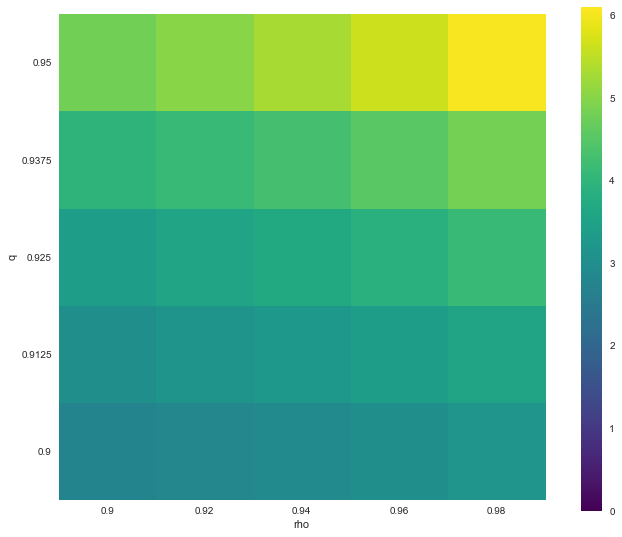

In [40]:
mql = np.empty((len(RHO_high), len(QQQ_high)))
rndx = np.arange(len(RHO_high))
qndx = np.arange(len(QQQ_high))
indices = np.array(np.meshgrid(
    np.arange(len(RHO_high)),
    np.arange(len(QQQ_high)))).T.reshape(-1,2)
for (r, q), (i, j) in zip(rqs_high, indices):
    k = (str(r), str(q))
    mql[i, j] = mean_queue_len(k)
f, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(mql, origin='lower', cmap='viridis', vmin=0, vmax=6.1)
ax.grid(False)
ax.set_xticks(rndx)
ax.set_xticklabels(RHO_high)
ax.set_xlabel('rho')
ax.set_yticks(qndx)
ax.set_yticklabels(QQQ_high)
ax.set_ylabel('q')

f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.15, 0.03, 0.7])
f.colorbar(im, cax=cbar_ax)
path = os.path.join(FIGFLDR, 'meanqueue_highparms.png')
f.savefig(path, dpi=300, bbox_inches='tight')
plt.show()